# Rubin ToO Strategies

Notebook template author: Igor Andreoni <igor.andreoni@gmail.com>

This notebook was put together to aid visualization of possible strategies to adopt for Target of Opportunity (ToO) observations with Vera C. Rubin Observatory. The template code was used to produce some figures published in Andreoni et al. (2022), The Astrophysical Journal Supplement Series, Volume 260, Issue 1, id.18, 17 pp.

### Requirements

Python3

- numpy
- matplotlib
- math
- collections

Custom scripts
- chart.py
- etc.py

### Run the cells

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from collections import OrderedDict
import pandas as pd

# Import the custom exposure time calculator
import etc

# Import the function to make the Gantt chart
from chart import makeChart

Build a dictionary with the strategies that you want to be seen on the same plot. 
The keys of the dictionary will be the nicknames of the strategies (for example, `strategy1`, `strategy2`).

Notes:
- The LSSTCam filter wheel holds 5 filters on a given night. The bluer and redder filters, u and y, will be swapped depending on the lunation. If all 6 filters are added to the plot, we shall assume that 5 available filters will be used in the ToOs.
- The length of the exposure time list (`exptimes` key) must be the same length as the cadence list (`cadence_hr` key) and the filters list (`filters` key)
- The cadence must be given in hours, the exposure times in seconds, the filters as a list or in the form `'ugrizy'`
- The `depths` are 5sigma limiting magnitudes in all bands, the corresponding exptime will be the median of the exposure times for the filters provided in each strategy
- <b>Important:</b> If both "depths" and "exposures" are given, "depths" will dominate.

In [2]:
strategies = {
    'Strategy 1': {"cadence_hr": [1, 4, 24, 48],
                   "exptimes": [30, 30, 60, 180],
                   "depths": [24, 24, 24, 24],
                   "filters": ['ugrizy', 'ugrizy', 'gz', 'gz']},
    'Strategy 2': {"cadence_hr": [1, 2, 4, 24],
                   "exptimes": [30, 30, 30, 180],
                   "depths": [24, 24, 24, 24],
                   "filters": ['gri', 'gz', 'gz', 'gz']},
    #'Strategy 3': {"cadence_hr": [1, 4, 24],
    #               "exptimes": [],
    #               "depths": [24, 24, 24],
    #               "filters": ['ugrizy', 'ugrizy', 'gz']},
}

# When is the timeline starting? e.g., Rubin Trigger, NS-NS merger, ...
event_name = "Rubin Trigger"

# Output file name
filename_out = "plot_strategy.pdf"

# Define the colors for the Rubin filters
filters_color_dict = {'u':'b', 'g':'g', 'r':'r', 'i':'yellow', 'z':'k', 'y':'orange'}

# Define the sequence of markers for different exposure times
# (the sequence will be ordered by increasing exposure time)
exptimes_marker_list = ["o", "s", "p", "h", "8", '^']

### Plot the Gantt chart


 Strategy name: Strategy 1
Using DEPTHS to calculate the exposure times
    Epoch: 24 hr
        Filter: u Depth: 24mag, exptime: 52s
        Filter: g Depth: 24mag, exptime: 5s
        Filter: r Depth: 24mag, exptime: 12s
        Filter: i Depth: 24mag, exptime: 24s
        Filter: z Depth: 24mag, exptime: 68s
        Filter: y Depth: 24mag, exptime: 433s
Median exposure time: 38s
    Epoch: 24 hr
        Filter: u Depth: 24mag, exptime: 52s
        Filter: g Depth: 24mag, exptime: 5s
        Filter: r Depth: 24mag, exptime: 12s
        Filter: i Depth: 24mag, exptime: 24s
        Filter: z Depth: 24mag, exptime: 68s
        Filter: y Depth: 24mag, exptime: 433s
Median exposure time: 38s
    Epoch: 24 hr
        Filter: g Depth: 24mag, exptime: 5s
        Filter: z Depth: 24mag, exptime: 68s
Median exposure time: 36s
    Epoch: 24 hr
        Filter: g Depth: 24mag, exptime: 5s
        Filter: z Depth: 24mag, exptime: 68s
Median exposure time: 36s

 Strategy name: Strategy 2
Using DEP

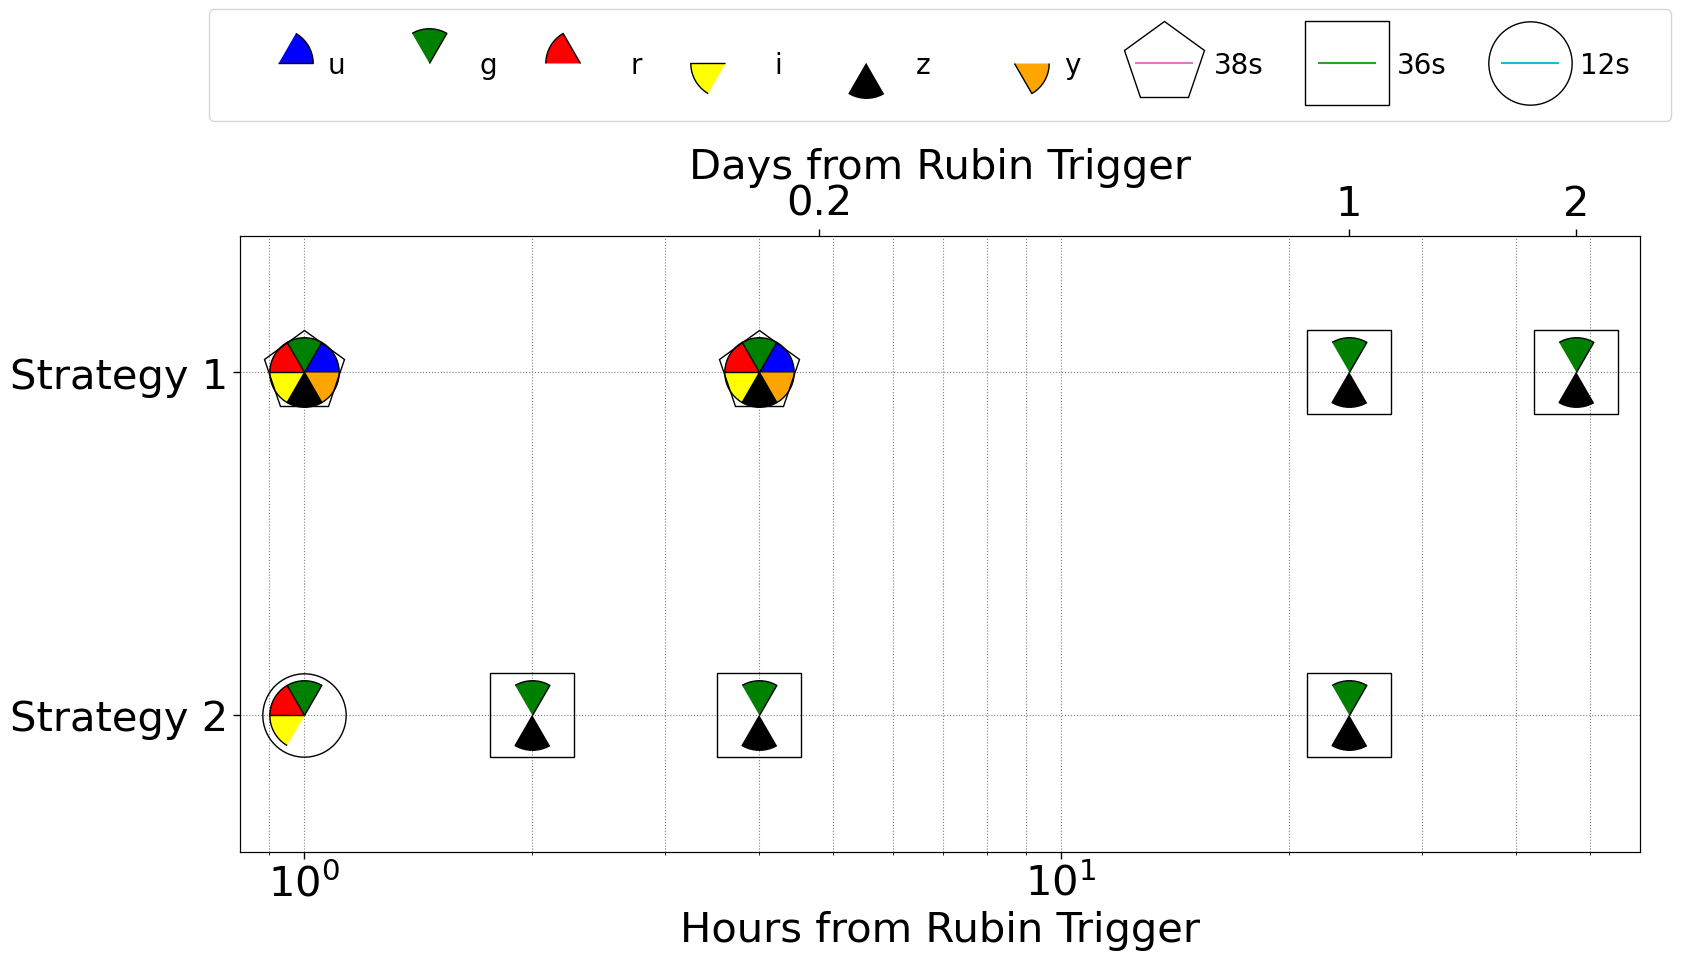

In [3]:
# If depths are given, then compute the exposure times
strategy_names = list(strategies.keys())
for i in range(len(strategy_names)):
    print(f"\n Strategy name: {strategy_names[i]}")
    if len(strategies[strategy_names[i]]["depths"]) > 0:
        print("Using DEPTHS to calculate the exposure times")
        # Initiate the exposure times list
        strategies[strategy_names[i]]["exptimes"] = []
        #Get exposure times, print results:
        for j in np.arange(len(strategies[strategy_names[i]]["depths"])):
            depth = strategies[strategy_names[i]]["depths"][j]
            # Iterate over the filters
            exptimes_epoch = [] # Get the average exposure time for a given epoch 
            print(f"    Epoch: {strategies[strategy_names[i]]['depths'][j]} hr")
            for filt in strategies[strategy_names[i]]["filters"][j]:
                exptime = int(np.round(etc.get_exptime(depth, filt)))
                print(f"        Filter: {filt} Depth: {depth}mag, exptime: {exptime}s")
                exptimes_epoch.append(exptime)
            # Add the average exposure time to the strategies dictionary
            strategies[strategy_names[i]]["exptimes"].append(int(np.round(np.median(exptimes_epoch))))
            print(f"Median exposure time: {int(np.round(np.median(exptimes_epoch)))}s")
    else:
        print("Using EXPOSURE TIMES to calculate the depths")

# Create the gantt chart
fig, ax = makeChart(strategies, event=event_name,
                    filters_color_dict=filters_color_dict,
                    exptimes_marker_list=exptimes_marker_list)

# Save the figure and show the plot
plt.savefig(filename_out, bbox_inches='tight')
plt.show()

### Plot transient light curve 

Plot the light curve of a transient given the strategy defined above.

In [4]:
# as a recap, print the strategies
strategies

{'Strategy 1': {'cadence_hr': [1, 4, 24, 48],
  'exptimes': [38, 38, 36, 36],
  'depths': [24, 24, 24, 24],
  'filters': ['ugrizy', 'ugrizy', 'gz', 'gz']},
 'Strategy 2': {'cadence_hr': [1, 2, 4, 24],
  'exptimes': [12, 36, 36, 36],
  'depths': [24, 24, 24, 24],
  'filters': ['gri', 'gz', 'gz', 'gz']}}

In [5]:
import glob

import numpy as np
from astropy.io import ascii
import matplotlib.pyplot as plt
from scipy import interpolate
from matplotlib.ticker import MaxNLocator
from astropy.cosmology import Planck18 as cosmo
import astropy.cosmology as ac
import astropy.units as u

For plotting kilonovae, choose relevant parameters

In [6]:
# redshift
z = 0.01

In [7]:
# For each strategy make a plot
strategy_names = list(strategies.keys())
for i in range(len(strategy_names)):
    print(f"\n Strategy name: {strategy_names[i]}")
    


 Strategy name: Strategy 1

 Strategy name: Strategy 2


### Time budget

In [8]:
import plot_lc


 Strategy name: Strategy 1


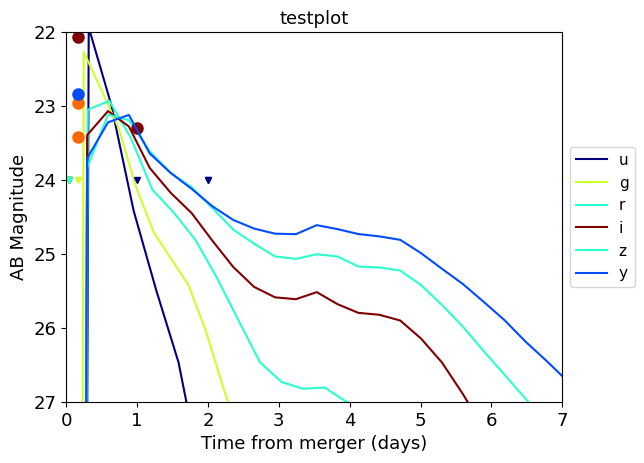


 Strategy name: Strategy 2


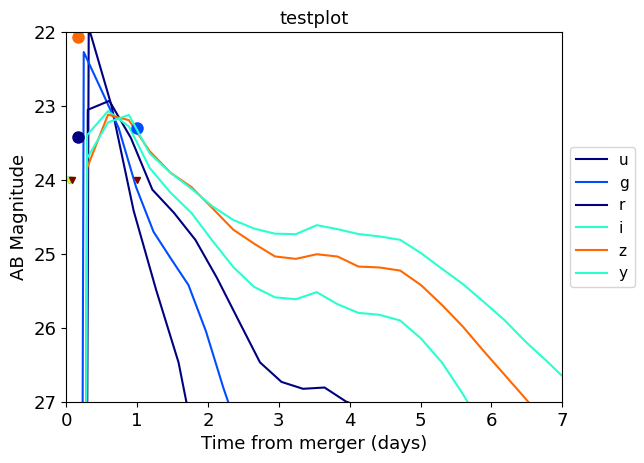

In [10]:
models = ["/Users/igor/Software/RubinToO2024/models/kilonova_Bulla/nph1.0e+06_dyn0.001-0.15-0.20_wind0.050-0.03_theta25.84_z0.2.dat",
          "/Users/igor/data/POSSIS/POSSIS_lc_June2023/nph1.0e+06_dyn0.001-0.15-0.20_wind0.050-0.03_theta90.00_z0.2.dat",
          "/Users/igor/data/POSSIS/POSSIS_lc_June2023/nph1.0e+06_dyn0.001-0.15-0.15_wind0.010-0.03_theta45.57_z0.2.dat",
          "/Users/igor/data/POSSIS/POSSIS_lc_June2023/nph1.0e+06_dyn0.001-0.15-0.15_wind0.050-0.03_theta25.84_z0.2.dat",
          "/Users/igor/data/POSSIS/POSSIS_lc_June2023/nph1.0e+06_dyn0.010-0.15-0.20_wind0.010-0.03_theta25.84_z0.2.dat",
          "/Users/igor/data/POSSIS/POSSIS_lc_June2023/nph1.0e+06_dyn0.020-0.15-0.20_wind0.090-0.03_theta25.84_z0.2.dat"]

filename = models[0]
t_model = ascii.read(filename)
plot_lc.doPlotLc(strategies, t_model, 'test.pdf', 'testplot')